In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import requests
#https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml

In [2]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

In [3]:
# Loads data
dataset = spark_session\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("data/data_file.csv",inferSchema = True)
#dataset = spark_session.read.format("libsvm").load("data/data_file.txt")

In [4]:
dataset.printSchema()
dataset.show()

root
 |-- label: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- adjClose: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- unadjustedVolume: double (nullable = true)
 |-- change: double (nullable = true)
 |-- changePercent: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- changeOverTime: double (nullable = true)

+----------+----------+----------+----------+----------+----------+----------------+--------+-------------+---------+--------------+
|     label|      high|       low|      open|  adjClose|    volume|unadjustedVolume|  change|changePercent|     vwap|changeOverTime|
+----------+----------+----------+----------+----------+----------+----------------+--------+-------------+---------+--------------+
|115.970001|117.589996|114.129997|115.550003|115.970001|1.380234E8|      1.380234E8|    0.42|        0.363|115.89666|       0.00363|
|    116.32|121.989998|116.

In [6]:
feature_list = []
for col in dataset.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
assembler

VectorAssembler_f435094ffe50

In [7]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features",featureSubsetStrategy="auto",
                           impurity='variance',maxBins=64)

In [8]:
# Now, we put our simple, two-stage workflow into an ML pipeline.
pipeline = Pipeline(stages=[assembler, rf])

In [9]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()
    #.addGrid(rf.maxBins, [int(x) for x in np.linspace(start = 32, stop = 64, num = 3)]) \
    

In [10]:
np.linspace(start = 32, stop = 64, num = 3)

array([32., 48., 64.])

In [11]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [12]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

+--------+
|   label|
+--------+
|0.115513|
|0.117188|
|0.117188|
|0.117188|
|0.117746|
|0.118304|
|0.118862|
|0.122768|
|0.123326|
|0.124442|
+--------+
only showing top 10 rows

None


In [13]:
cvModel = crossval.fit(trainingData)

In [14]:
predictions = cvModel.transform(testData)

In [15]:
print(predictions.select("prediction", "label", "features").show(10))
print(trainingData.select("label").show(10))

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
| 0.3538882563581436|0.116629|[0.11942,0.116071...|
| 0.3538882563581436|0.117746|[0.119978,0.11383...|
| 0.3538882563581436|0.118862|[0.11942,0.116071...|
| 0.3538882563581436| 0.12221|[0.123884,0.11607...|
| 0.3538882563581436| 0.12221|[0.123884,0.11830...|
| 0.3538882563581436| 0.12221|[0.123884,0.12165...|
| 0.3538882563581436|0.123326|[0.125,0.122768,0...|
| 0.3538882563581436|0.131138|[0.132254,0.13058...|
|0.36556153236239586|0.135603|[0.138393,0.11886...|
| 0.3538882563581436|0.136719|[0.138951,0.13616...|
+-------------------+--------+--------------------+
only showing top 10 rows

None
+--------+
|   label|
+--------+
|0.115513|
|0.117188|
|0.117188|
|0.117188|
|0.117746|
|0.118304|
|0.118862|
|0.122768|
|0.123326|
|0.124442|
+--------+
only showing top 10 rows

None


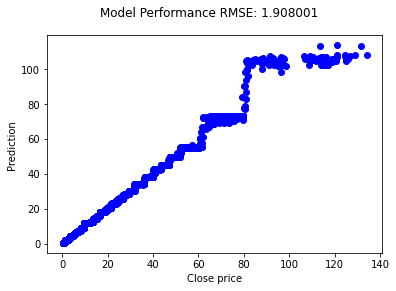

1.9080013411012435


In [16]:
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(dataset)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print(rmse)

In [17]:
rmse

1.9080013411012435

Text(0.5, 1.0, 'Feature Importances')

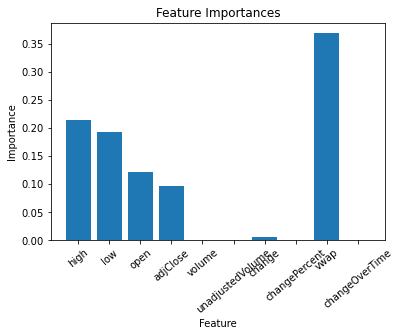

In [18]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [19]:
dataset.select("changePercent").show()

+-------------+
|changePercent|
+-------------+
|        0.363|
|       -3.469|
|        0.313|
|        0.916|
|         0.71|
|        0.711|
|       -0.312|
|       -1.981|
|        2.625|
|       -3.346|
|        0.961|
|        0.912|
|        -1.16|
|       -1.447|
|        0.171|
|        1.127|
|       -3.318|
|       -1.863|
|        1.676|
|        0.157|
+-------------+
only showing top 20 rows

